In [9]:
# 初期設定とインポート
from pathlib import Path
import re
from typing import Dict, List, Optional

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 研究ノートは research/ 配下想定。プロジェクトルートを自動算出
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "research":
    PROJECT_ROOT = PROJECT_ROOT.parent  # c:/Users/sohta/equity01

UNIVERSE_DIR = PROJECT_ROOT / "data" / "intermediate" / "universe"
LATEST = UNIVERSE_DIR / "latest_universe.parquet"
PAT = re.compile(r"(\d{8})_universe\.parquet$")

# スタイル設定
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

print("カレント:", Path.cwd())
print("プロジェクト:", PROJECT_ROOT)
print("ユニバースDIR:", UNIVERSE_DIR)
print("latest存在:", LATEST.exists())


カレント: c:\Users\sohta\equity01
プロジェクト: C:\Users\sohta\equity01
ユニバースDIR: C:\Users\sohta\equity01\data\intermediate\universe
latest存在: True


## 1. データ読み込み


In [17]:
# データ読み込み関数の定義
def _latest_snapshot_path() -> Optional[Path]:
    files = [p for p in UNIVERSE_DIR.glob("*_universe.parquet") if PAT.search(p.name)]
    if not files:
        return None
    files = sorted(files, key=lambda p: PAT.search(p.name).group(1))
    return files[-1]

def load_latest_universe() -> pd.DataFrame:
    """latest_universe.parquet が無ければ最新スナップショットを読む"""
    if LATEST.exists():
        return pd.read_parquet(LATEST)
    p = _latest_snapshot_path()
    if p is None:
        raise FileNotFoundError(f"No universe parquet found under: {UNIVERSE_DIR}")
    return pd.read_parquet(p)

def load_historical_universes(limit: int = 120) -> Dict[str, pd.DataFrame]:
    """YYYYMMDDをキーに過去スナップショットを読み込む（最大limit本）"""
    files = sorted(
        [p for p in UNIVERSE_DIR.glob("*_universe.parquet") if PAT.search(p.name)],
        key=lambda p: PAT.search(p.name).group(1),
    )[-limit:]
    out: Dict[str, pd.DataFrame] = {}
    for p in files:
        ymd = PAT.search(p.name).group(1)
        out[ymd] = pd.read_parquet(p)
    return out

def calc_daily_overlap(unis: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """前日比の一致率（前日集合に対する一致率）"""
    if not unis:
        return pd.DataFrame(columns=["date","overlap_rate","count_today","count_prev"])
    dates: List[str] = sorted(unis.keys())
    rows = []
    prev = None
    for d in dates:
        cur = set(unis[d]["ticker"].astype(str))
        if prev is None:
            rows.append({"date": d, "overlap_rate": None, "count_today": len(cur), "count_prev": None})
        else:
            inter = len(cur & prev)
            denom = len(prev)
            rows.append({"date": d, "overlap_rate": (inter/denom if denom else None),
                         "count_today": len(cur), "count_prev": len(prev)})
        prev = cur
    return pd.DataFrame(rows)

# 最新のユニバースを読み込む
df_universe = load_latest_universe()
print(f"ユニバース銘柄数: {len(df_universe)}")
print(f"\n{df_universe.head()}")
print(f"\nカラム: {df_universe.columns.tolist()}")


ユニバース銘柄数: 27

   ticker  avg_turnover  liquidity_rank        asof
0  9984.T  2.240259e+11               1  2025-11-09
1  8035.T  1.170208e+11               2  2025-11-09
2  8306.T  8.947497e+10               3  2025-11-09
3  7203.T  7.539640e+10               4  2025-11-09
4  7974.T  6.536661e+10               5  2025-11-09

カラム: ['ticker', 'avg_turnover', 'liquidity_rank', 'asof']


## 2. 一致率（日次変化）


In [18]:
# 一致率（日次変化）の計算
# Cell 4で定義した関数を使用
unis = load_historical_universes(limit=30)
overlap_df = calc_daily_overlap(unis)

if not overlap_df.empty:
    print("一致率（日次変化）:")
    print(overlap_df.tail(10))
    
    # 平均一致率を計算
    valid_rates = overlap_df["overlap_rate"].dropna()
    if len(valid_rates) > 0:
        print(f"\n平均一致率: {valid_rates.mean():.2%}")
        print(f"最小一致率: {valid_rates.min():.2%}")
        print(f"最大一致率: {valid_rates.max():.2%}")
else:
    print("過去のユニバースデータが不足しています。")


一致率（日次変化）:
       date  overlap_rate  count_today  count_prev
0  20250930           NaN           27         NaN
1  20251108           1.0           27        27.0
2  20251109           1.0           27        27.0

平均一致率: 100.00%
最小一致率: 100.00%
最大一致率: 100.00%


## 3. セクター偏り


In [19]:
# セクター分布を可視化
if 'df_universe' in locals() and 'sector' in df_universe.columns:
    sector_counts = df_universe["sector"].value_counts()
    sector_weights = df_universe.groupby("sector")["weight"].sum()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # 銘柄数
    sector_counts.plot(kind="bar", ax=ax1)
    ax1.set_title("セクター別銘柄数")
    ax1.set_xlabel("セクター")
    ax1.set_ylabel("銘柄数")
    ax1.tick_params(axis="x", rotation=45)
    
    # ウェイト
    sector_weights.plot(kind="bar", ax=ax2)
    ax2.set_title("セクター別ウェイト合計")
    ax2.set_xlabel("セクター")
    ax2.set_ylabel("ウェイト合計")
    ax2.tick_params(axis="x", rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\nセクター統計:")
    print(sector_weights.describe())


## 4. OOS安定性


In [20]:
# 時系列でのユニバースサイズ・構成の安定性を確認
# TODO: 実際のデータで実装
print("OOS安定性の検証は、過去のユニバースデータが必要です")
print("historical_universes を使用して以下を確認:")
print("- ユニバースサイズの変動")
print("- セクター構成の変動")
print("- 銘柄の滞在期間")
# 例：四半期末と直近で作る
# python scripts/universe_builder.py --config configs/universe.yml --asof 2025-09-30
# python scripts/universe_builder.py --config configs/universe.yml --asof 2025-10-31
# python scripts/universe_builder.py --config configs/universe.yml --asof 2025-11-08
# python scripts/universe_builder.py --config configs/universe.yml --asof 2025-11-09

OOS安定性の検証は、過去のユニバースデータが必要です
historical_universes を使用して以下を確認:
- ユニバースサイズの変動
- セクター構成の変動
- 銘柄の滞在期間


## 5. 流動性・規模分布


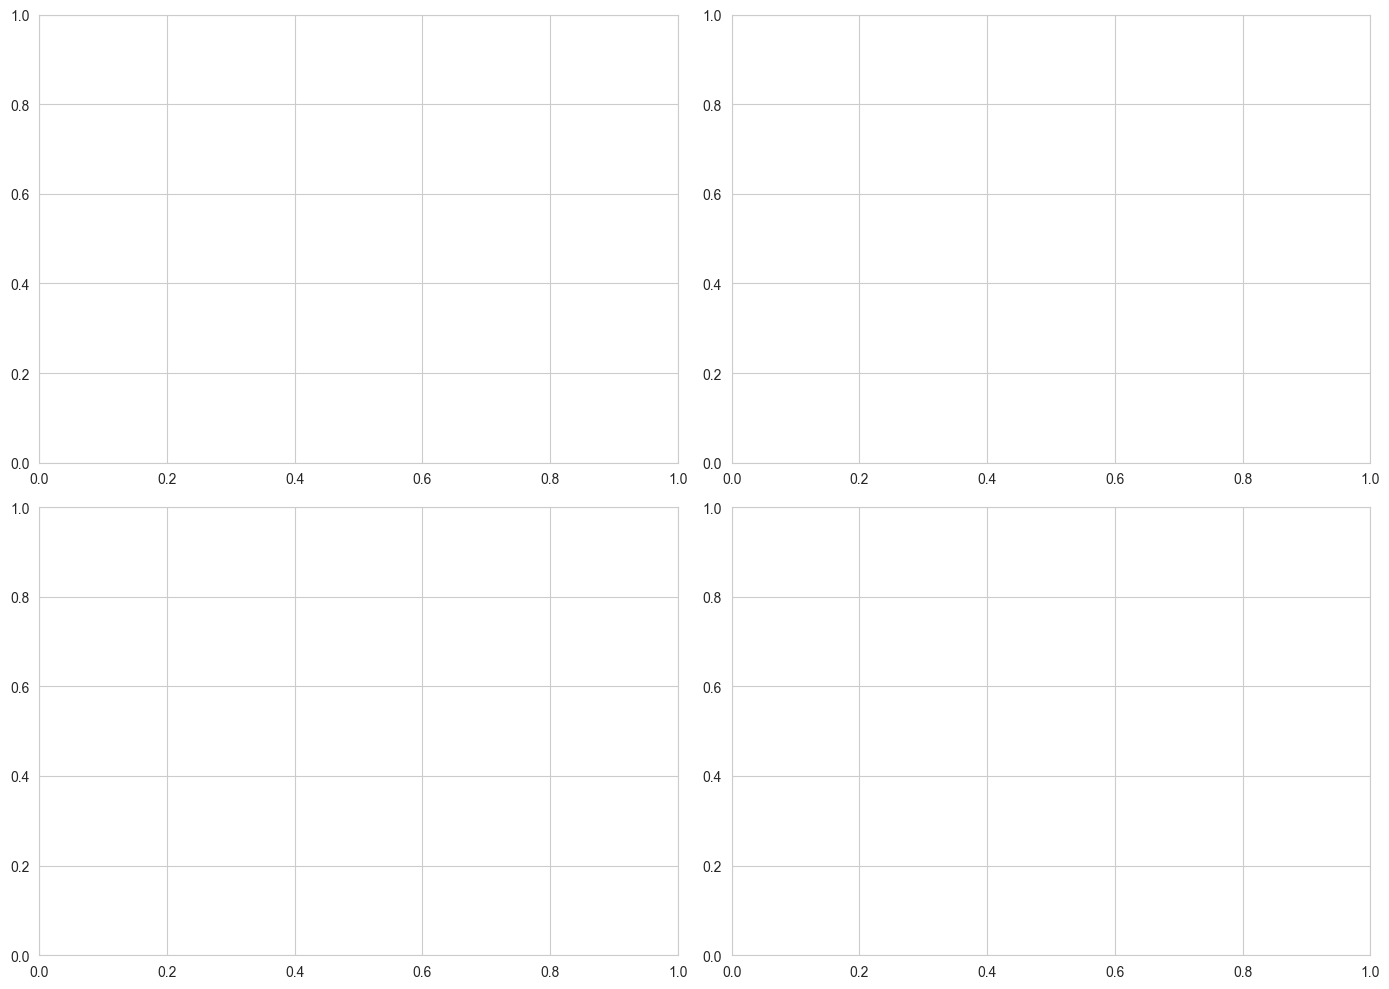


統計サマリー:
       avg_turnover  liquidity_rank
count  2.700000e+01       27.000000
mean   4.175358e+10       14.000000
std    4.542465e+10        7.937254
min    9.336359e+09        1.000000
25%    1.507836e+10        7.500000
50%    2.634125e+10       14.000000
75%    5.515756e+10       20.500000
max    2.240259e+11       27.000000


In [21]:
# 流動性・規模の分布を可視化
if 'df_universe' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 時価総額分布
    if 'market_cap' in df_universe.columns:
        df_universe["market_cap_log"] = np.log10(df_universe["market_cap"] + 1)
        df_universe["market_cap_log"].hist(bins=30, ax=axes[0, 0])
        axes[0, 0].set_title("時価総額分布（対数）")
        axes[0, 0].set_xlabel("log10(時価総額)")
        axes[0, 0].set_ylabel("銘柄数")
    
    # 出来高分布
    if 'avg_volume' in df_universe.columns:
        df_universe["avg_volume_log"] = np.log10(df_universe["avg_volume"] + 1)
        df_universe["avg_volume_log"].hist(bins=30, ax=axes[0, 1])
        axes[0, 1].set_title("平均出来高分布（対数）")
        axes[0, 1].set_xlabel("log10(出来高)")
        axes[0, 1].set_ylabel("銘柄数")
    
    # ウェイト分布
    if 'weight' in df_universe.columns:
        df_universe["weight"].hist(bins=30, ax=axes[1, 0])
        axes[1, 0].set_title("ウェイト分布")
        axes[1, 0].set_xlabel("ウェイト")
        axes[1, 0].set_ylabel("銘柄数")
    
    # セグメント別分布
    if 'segment' in df_universe.columns:
        df_universe["segment"].value_counts().plot(kind="bar", ax=axes[1, 1])
        axes[1, 1].set_title("セグメント別銘柄数")
        axes[1, 1].set_xlabel("セグメント")
        axes[1, 1].set_ylabel("銘柄数")
        axes[1, 1].tick_params(axis="x", rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 統計サマリー
    print("\n統計サマリー:")
    numeric_cols = df_universe.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(df_universe[numeric_cols].describe())


## 6. 検証レポート生成


In [22]:
# 検証結果をサマリー
if 'df_universe' in locals():
    print("=" * 60)
    print("ユニバース検証レポート")
    print("=" * 60)
    print(f"\n銘柄数: {len(df_universe)}")
    
    if 'weight' in df_universe.columns:
        print(f"\nウェイト合計: {df_universe['weight'].sum():.4f}")
        print(f"最大ウェイト: {df_universe['weight'].max():.4f}")
        print(f"最小ウェイト: {df_universe['weight'].min():.4f}")
    
    if 'sector' in df_universe.columns:
        print(f"\nセクター数: {df_universe['sector'].nunique()}")
        print(f"\nセクター別銘柄数:")
        print(df_universe["sector"].value_counts())
    
    if 'segment' in df_universe.columns:
        print(f"\nセグメント別銘柄数:")
        print(df_universe["segment"].value_counts())
    
    print("\n" + "=" * 60)


ユニバース検証レポート

銘柄数: 27



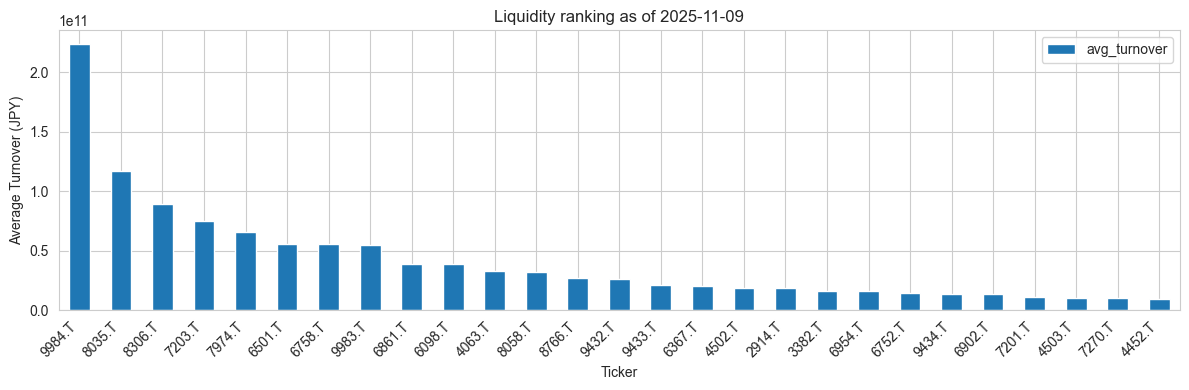

In [23]:
# 流動性ランキングの可視化
if 'df_universe' in locals() and len(df_universe) > 0:
    df_universe.plot.bar(x="ticker", y="avg_turnover", figsize=(12,4))
    plt.title(f"Liquidity ranking as of {df_universe['asof'].iloc[0]}")
    plt.ylabel("Average Turnover (JPY)")
    plt.xlabel("Ticker")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("df_universeが定義されていません。Cell 4を先に実行してください。")
